## 1. Generate Synthetic Data
First, we generate synthetic data from a three-dimensional GMM.

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Function to display the latent space with dots
def plot_latent_space_with_points(latent, labels=None, xmin=-150, xmax=150, ymin=-150, ymax=150):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    scatter = ax.scatter(latent[:, 0], latent[:, 1], c=labels, cmap='viridis', alpha=0.6)
    if labels is not None:
        plt.colorbar(scatter, ax=ax, label='Component')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title('Latent space Z with Points')

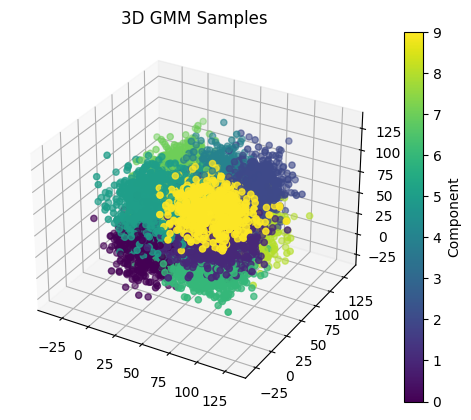

In [ ]:
# Generate GMM synthetic data
def generate_gmm_data(n_samples=10000, n_components=10, random_seed=42):
    np.random.seed(random_seed)
    gmm = GaussianMixture(n_components=n_components, random_state=random_seed)
    # Create randomized training data to adjust the GMM
    X_train = np.random.rand(n_samples, 3) * 100
    gmm.fit(X_train)
    X, y = gmm.sample(n_samples)
    return X, y, gmm

# Generate 10,000 samples from a GMM with 10 components
X, y, gmm = generate_gmm_data(n_samples=10000, n_components=10)

# Visualize the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
plt.colorbar(scatter, ax=ax, label='Component')
plt.title('3D GMM Samples')
plt.show()


## 2. Defining the VAE with Dense Layers
We define the VAE using dense layers instead of convolutional layers.

In [ ]:
# Define the encoder architecture
class DenseEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(DenseEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc3_logvar = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        h = self.relu(self.bn1(self.fc1(x)))
        h = self.dropout(h)
        h = self.relu(self.bn2(self.fc2(h)))
        h = self.dropout(h)
        z_mean = self.fc3_mean(h)
        z_logvar = self.fc3_logvar(h)
        return z_mean, z_logvar

# Define the decoder architecture
class DenseDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(DenseDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.4)

    def forward(self, z):
        h = self.relu(self.bn1(self.fc1(z)))
        h = self.dropout(h)
        h = self.relu(self.bn2(self.fc2(h)))
        h = self.dropout(h)
        x_recon = self.sigmoid(self.fc3(h))
        return x_recon

# Define the complete VAE architecture
class DenseVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(DenseVAE, self).__init__()
        self.encoder = DenseEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = DenseDecoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, z_mean, z_logvar):
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_recon = self.decoder(z)
        return x_recon, z_mean, z_logvar

    def loss_function(self, x, x_recon, z_mean, z_logvar):
        recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
        return recon_loss + kl_divergence, recon_loss, kl_divergence

In [ ]:
# Initialize the VAE
input_dim = 3
hidden_dim = 512
latent_dim = 10
vae = DenseVAE(input_dim, hidden_dim, latent_dim)

## 3. Training the VAE
We train the VAE using the generated data set.

In [ ]:
# Preparing the DataLoader
batch_size = 64
tensor_x = torch.Tensor(X)  # convert to torch tensor
dataset = TensorDataset(tensor_x, tensor_x)  # make a dataset with inputs and targets the same
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

# Training the model
epochs = 100
vae.train()
for epoch in range(epochs):
    train_loss = 0.0
    for x_batch, _ in trainloader:
        optimizer.zero_grad()
        x_batch = x_batch.float()
        x_recon, z_mean, z_logvar = vae(x_batch)
        loss, recon_loss, kl_divergence = vae.loss_function(x_batch, x_recon, z_mean, z_logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader.dataset):.4f}')

Epoch 1, Loss: 9734.2879
Epoch 2, Loss: 9681.6189
Epoch 3, Loss: 9671.4808
Epoch 4, Loss: 9667.8603
Epoch 5, Loss: 9666.2463
Epoch 6, Loss: 9665.4253
Epoch 7, Loss: 9664.9342
Epoch 8, Loss: 9664.5934
Epoch 9, Loss: 9664.3488
Epoch 10, Loss: 9664.1568
Epoch 11, Loss: 9664.0135
Epoch 12, Loss: 9663.8927
Epoch 13, Loss: 9663.7951
Epoch 14, Loss: 9663.7082
Epoch 15, Loss: 9663.6356
Epoch 16, Loss: 9663.5718
Epoch 17, Loss: 9663.5215
Epoch 18, Loss: 9663.4716
Epoch 19, Loss: 9663.4288
Epoch 20, Loss: 9663.3943
Epoch 21, Loss: 9663.3621
Epoch 22, Loss: 9663.3334
Epoch 23, Loss: 9663.3090
Epoch 24, Loss: 9663.2887
Epoch 25, Loss: 9663.2687
Epoch 26, Loss: 9663.2528
Epoch 27, Loss: 9663.2385
Epoch 28, Loss: 9663.2267
Epoch 29, Loss: 9663.2161
Epoch 30, Loss: 9663.2069
Epoch 31, Loss: 9663.1991
Epoch 32, Loss: 9663.1926
Epoch 33, Loss: 9663.1876
Epoch 34, Loss: 9663.1829
Epoch 35, Loss: 9663.1791
Epoch 36, Loss: 9663.1758
Epoch 37, Loss: 9663.1733
Epoch 38, Loss: 9663.1705
Epoch 39, Loss: 9663.

## 4. Generate and Compare Images
We generate new samples using the VAE and compare with the original distribution.

<ipython-input-13-1aa816420dd5>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(generated_samples[:, 0], generated_samples[:, 1], generated_samples[:, 2], cmap='viridis')


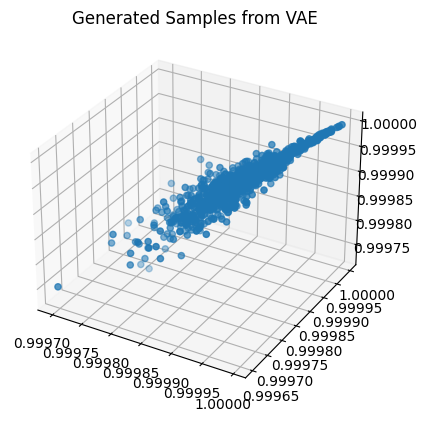

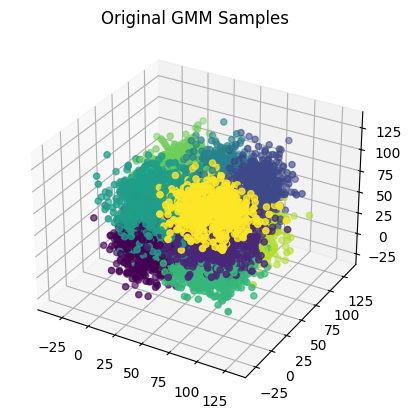

In [ ]:
# Generate new samples
vae.eval()
with torch.no_grad():
    z_samples = torch.randn(1000, latent_dim)
    generated_samples = vae.decoder(z_samples).numpy()

# Display the generated samples
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(generated_samples[:, 0], generated_samples[:, 1], generated_samples[:, 2], cmap='viridis')
plt.title("Generated Samples from VAE")
plt.show()

# Display the original samples
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
plt.title("Original GMM Samples")
plt.show()

## 5. Visualization with t-SNE
We visualize the original and generated samples in latent space using t-SNE.

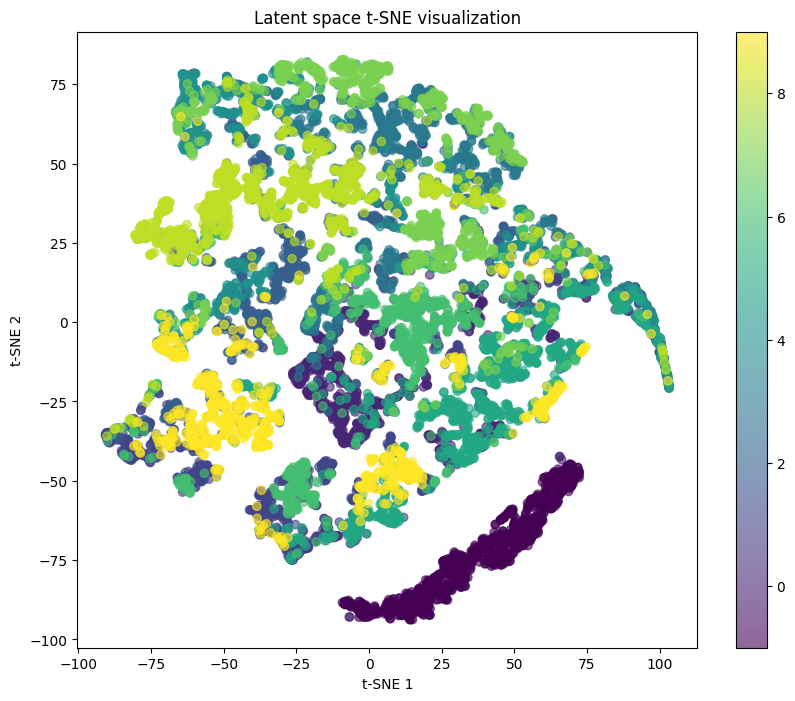

In [ ]:
import torch
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Obtain latent representations of the original samples
vae.eval()
with torch.no_grad():
    z_mean_orig, _ = vae.encoder(torch.Tensor(X).float())
    z_mean_orig = z_mean_orig.numpy()

# Generate new samples and obtain their latent representations
z_samples = torch.randn(1000, latent_dim)
with torch.no_grad():
    generated_samples = vae.decoder(z_samples)
    z_mean_gen, _ = vae.encoder(generated_samples)

# Combining latent representations
all_z_means = np.vstack((z_mean_orig, z_mean_gen.cpu().detach().numpy()))

# Labels to distinguish groups in the display
labels = np.concatenate([y, np.full(shape=z_mean_gen.shape[0], fill_value=-1)])  # Etiqueta -1 para generadas

# Apply t-SNE
latent_tsne = TSNE(n_components=2).fit_transform(all_z_means)

# Display with t-SNE
def plot_latent_space_with_points(latent, labels, title='Latent space t-SNE visualization'):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent[:, 0], latent[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

# Calling the display function
plot_latent_space_with_points(latent_tsne, labels)